# Airy's Equation

In this file we demonstrate the mgo implementation on the Airy Problem:
$$
\partial_x^2 \psi(x) - x \psi(x) = 0.
$$
The corresponding local dispersion relation for Airy's equation is:
$$
\mathcal{D}(x, k) = - k^2 - x = 0
$$

In [476]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from scipy.special import airy
from scipy.signal import find_peaks
# from diff_func_fitters import fit_polynomial
from gauss_freud_quad import get_nodes_and_weights
from baryrat import aaa

import mgo

Plot settings:

In [477]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 16

### Dispersion Relation

In [478]:
@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return - x - k**2

def get_k0(x0):
    return np.sqrt(-x0)

#### Ray Tracing and MGO Field Reconstruction

In [479]:
max_gauss_quad_order = 10

def get_mgo_field(phi0, t, zs, i_start, i_end, analytic_cont, i_save=[], fixed_params={}):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0, i_start, i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order, fixed_params=fixed_params)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [480]:
# Exact solution gives initial conditions
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

xi = np.linspace(-8, 0, 200)
E_ex = Ai(xi) # Exact solution is Airy function

x0 = np.min(xi)
phi0 = Ai(x0)

# # Set ICs from Airy function
# first_peak_ind = find_peaks(E_ex)[0][0]
# x0  = xi[first_peak_ind]
# phi0 = E_ex[first_peak_ind]

x1 = xi[find_peaks(E_ex)[0][1]]
phi1 = E_ex[find_peaks(E_ex)[0][1]]

In [481]:
k0 = get_k0(x0)
ND = 1
nt = 1000
omega0 = 1.0
t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=0, tmax=8, D=D, x_min=x0, tsteps=nt, rtol=1e-9, ghost_ratio=0.1)
nt = i_end - i_start

i_caust = np.argmin(np.abs(fd.grad(zs[i_start:i_end,..., :1].squeeze(), t[i_start:i_end])))
i_save = [0, int(i_caust/2), i_caust, i_caust + int((nt-1 - i_caust)/2), nt-1]

In [482]:
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}}
branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, analytic_cont=analytic_cont, i_save=i_save)

In [483]:
field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
sorted_results=sorted(results, key=lambda d: d['t1'])

branch_masks_go, ray_field_go = mgo.get_go_field_1D(t, zs, phi0=phi0, i_start=i_start, i_end=i_end)
field_go = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=branch_masks_go, ray_field=ray_field_go, i_start=i_start, i_end=i_end)

## Plots for Article

In [484]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11

cm = 1/2.54 # 1 cm = 1/2.54 inch

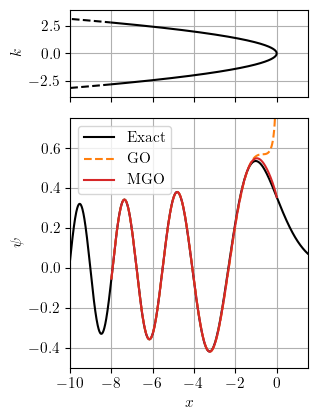

In [485]:
xi_full = np.linspace(-10, 1.5, 1000)
xi = np.linspace(-8, 0, 1000)

nrows, ncols = 7, 1
fig = plt.figure(figsize=(8.4*cm, 11*cm))
gs = GridSpec(nrows, ncols, figure=fig)

ax0 = fig.add_subplot(gs[:2, 0])
ax1 = fig.add_subplot(gs[2:, 0])

ax0.sharex(ax1)
ax0.plot(xs[i_start:i_end], ks[i_start:i_end], '-k')
ax0.plot(xs[:i_start], ks[:i_start], '--k')
ax0.plot(xs[i_end:], ks[i_end:], '--k')
ax0.tick_params('x', labelbottom=False)
# ax0.set_xlim(np.min(xi_full), np.max(xi_full))
# ax0.set_xticks(np.arange(-10, 2, 2))
# ax0.set_xlabel('$x$')
ax0.set_ylabel('$k$')
ax0.grid()

ax1.plot(xi_full, Ai(xi_full), 'k-', label='Exact')
ax1.plot(xi, np.real(field_go(xi)), '--', color='tab:orange', label='GO')
ax1.plot(xi, np.real(field(xi)), '-', color='tab:red', label='MGO')
ax1.grid()
ax1.set_xlim(np.min(xi_full), np.max(xi_full))
ax1.set_xticks(np.arange(-10, 2, 2))
ax1.set_ylim(-0.5, 0.75)
ax1.legend()
# ax1.legend(bbox_to_anchor=(1,0.5), loc="center left")
ax1.set_xlabel('$x$')
ax1.set_ylabel('$\psi$')

fig.tight_layout()

plt.savefig('./plots/airy_mgo.pdf')
plt.savefig('./plots/airy_mgo.png', dpi=300)
plt.show()

In [486]:
# Define analytical functions for comparison with numerical results
v_ex = lambda k: np.sqrt(1+4*(k**2))
f_ex = lambda eps, k: (
    (v_ex(k)**6 - (v_ex(k)**4 - 8*v_ex(k)*k*eps)**(3/2))/(96*(k**3))
    - v_ex(k)**3/(8*(k**2)) * eps + v_ex(k)**2/(4*k) * eps**2
    )
Phi_ex = lambda eps, k: v_ex(k)/(v_ex(k)**4 - 8*v_ex(k)*k*eps)**(1/4)

Theta_ex = lambda eps, k: (
    (8*(k**4) - (v_ex(k)**4))
    / (8*(k**2) * v_ex(k)) * eps
    + (1/(4*k)) * (eps **2)
    + ((v_ex(k)**6) - (v_ex(k)**4 - 8 * k * v_ex(k) * eps)**(3/2))
    / (96*(k**3))
    )

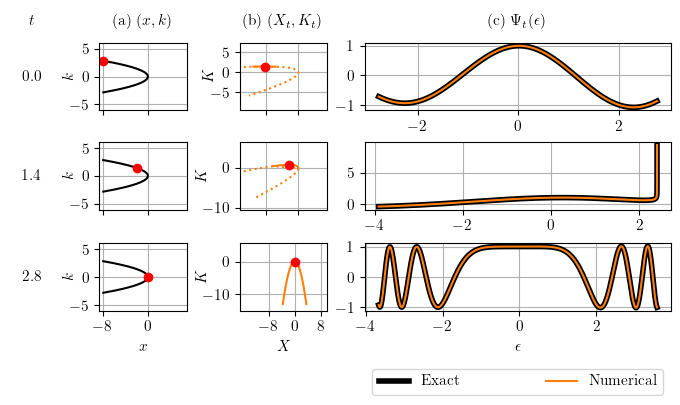

In [487]:
Nr = 3

nrows = 2+Nr*3
n_cols = 12
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 10*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == Nr - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 5), slice(5, 12)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $(X_t, K_t)$', r'(c) $\Psi_t(\epsilon)$']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

for i, result in enumerate(sorted_results[:Nr]):
    t1, it_all, mask_t1, it1, eps_rho, S_t1, Xs_t1_all, Xs_t1, Ks_t1, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'it1', 'eps_rho', 'S_t1', 'Xs_t1_all', 'Xs_t1', 'Ks_t1', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    Ks_t1_all = (S_t1[ND:, :] @ zs[:, :, np.newaxis])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 1)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')


    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(xs, ks, '-', alpha=0)
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.plot(Xs_t1.squeeze(), Ks_t1.squeeze(), '-', color='tab:orange')
    ax.plot(Xs_t1_all[~mask_t1].squeeze(), Ks_t1_all[~mask_t1].squeeze(), ':', color='tab:orange')
    ax.plot(Xs_t1[it1], Ks_t1[it1], 'ro')
    ax.grid()
    ax.set_ylabel(r'$K$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$X$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, np.real(Phi_ex(eps_rho, ks[it_all]) * np.exp(1j*Theta_ex(eps_rho, ks[it_all]))), '-', linewidth=4, color='k')
    ax.plot(eps_rho, np.real(Phi_t1 * np.exp(1j*Theta_t1)), '-', color='tab:orange')
    # ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

ax = fig.add_subplot(gs[-1:, slice(col_ranges[-1].start, col_ranges[-1].stop)])
ax.plot(1, '-', color='k', linewidth=4, label='Exact')
ax.plot(1, '-', color='tab:orange', label='Numerical')
plt.axis('off')
ax.legend(mode='expand', ncols=2)

fig.savefig('./plots/airy_mgo_steps_1.pdf')
# fig.savefig('./plots/airy_mgo_steps_1.png', dpi=300)
plt.show()

In [488]:
C = lambda l, sigma_p, sigma_m, lamb: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: lamb*np.exp(1j*sigma_m), lambda l: lamb*np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m, lamb: np.real(C(l, sigma_p, sigma_m, lamb))
C_I = lambda l, sigma_p, sigma_m, lamb: np.imag(C(l, sigma_p, sigma_m, lamb))

def get_eps(lamb, gauss_quad_order):
    l_j, _ = get_nodes_and_weights(gauss_quad_order)
    lmax = np.max(l_j)
    l_j = l_j.astype(np.complex_)

    epsmax = max(lamb * lmax)
    eps_R = np.linspace(-epsmax,epsmax, 1000)
    eps_I = np.linspace(-epsmax,epsmax, 1000)
    Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
    Eps = Eps_R + 1j*Eps_I
    return Eps_R, Eps_I, Eps, l_j

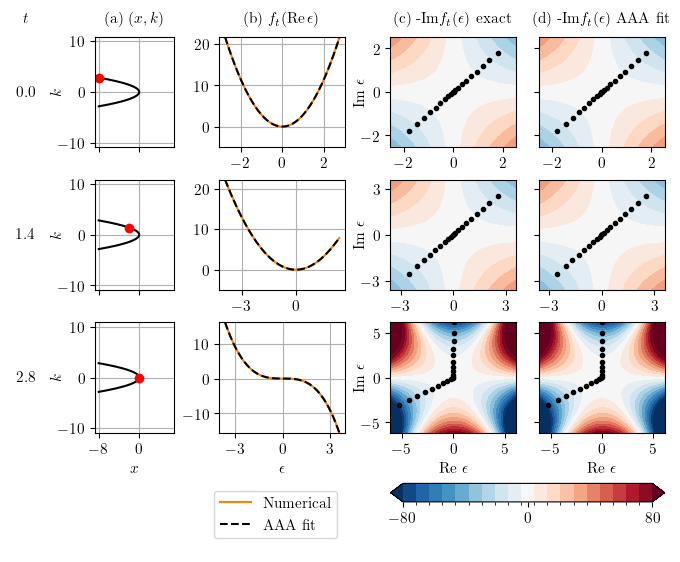

In [489]:
vmin, vmax = -80, 80
cmap = mpl.cm.RdBu_r
levels = np.linspace(vmin, vmax, 20)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')

Nr = 3
nrows = 3+Nr*3
n_cols = 12
fig = plt.figure(constrained_layout=True, figsize=(17*cm, 14*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == Nr - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 6), slice(6, 9), slice(9, 12)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $f_t(\mathrm{Re}\, \epsilon)$', r'(c) -Im$f_t(\epsilon)$ exact', r'(d) -Im$f_t(\epsilon)$ AAA fit']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

get_eps_xticks = lambda eps_rho: [-5]*int(np.min(eps_rho) <= -5) + [-2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [0] + [2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [5]*int(np.max(eps_rho) >= 5)

for i, result in enumerate(sorted_results[:Nr]):
    t1, it_all, mask_t1, eps_rho, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), 0:1])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 1)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(eps_rho, f_t1, '-', color='tab:orange')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='k')
    ax.set_ylim(max(min(-5, np.min(f_t1)), -50), min(max(5, np.max(f_t1)), 50))
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')
    # ax.set_xticks(get_eps_xticks(eps_rho))
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(eps_rho))*2/3))))

    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_ex(Eps.reshape(-1, 1), ks[it_all]).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_R))*2/3))))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_I))*2/3))))

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    # ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    plt.tick_params('y', labelleft=False)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_R))*2/3))))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_I))*2/3))))

ax = fig.add_subplot(gs[-2:, slice(col_ranges[2].start, col_ranges[2].stop)])
ax.plot(1, '-', color='tab:orange', label='Numerical')
ax.plot(1, '--', color='k', label='AAA fit')
plt.axis('off')
ax.legend()

cax = fig.add_subplot(gs[-2:-1, slice(col_ranges[-2].start, col_ranges[-1].stop)])
c_ticks = [vmin, 0, vmax]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, ticks=c_ticks, orientation='horizontal', extend='both')

# plt.tight_layout()
# fig.savefig('./plots/airy_mgo_steps_2.pdf')
fig.savefig('./plots/airy_mgo_steps_2.png', dpi=300)
plt.show()

### Plots of the Error of the MGO Solution

#### Number of Quadrature Points

In [490]:
num_study_quad = []
for n in range(1, 11):
    analytic_cont = {'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}}
    _branch_masks, _ray_field, _mgo_info, _results, _Nt, _Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, analytic_cont=analytic_cont, i_save=i_save, fixed_params={'epsmax': np.inf, 'gauss_quad_order': n})
    _A0, _interp_field = mgo.get_A0_and_interpolation(phi0=phi1, x0=x1, xs=xs, i_start=i_start, i_end=i_end, branch_masks=_branch_masks, ray_field=_ray_field)
    _field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=_branch_masks, ray_field=_ray_field, i_start=i_start, i_end=i_end)
    _sorted_results=sorted(results, key=lambda d: d['t1'])
    num_study_quad.append({
        'n': n,
        'branch_masks': _branch_masks, 'ray_field': _ray_field, 'mgo_info': _mgo_info, 'results': _results, 'Nt': _Nt, 'Upsilon': _Upsilon,
        'A0': _A0, 'interp_field': _interp_field,
        'field': _field,
        'sorted_results': _sorted_results
    })

In [491]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 11

cm = 1/2.54 # 1 cm = 1/2.54 inch

##### Option 1: Deviation as function of position

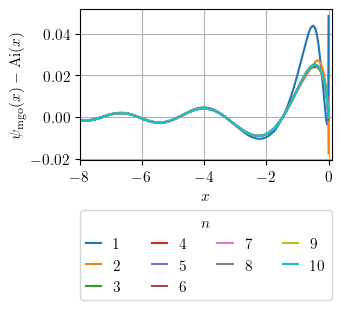

In [492]:
xi = np.linspace(-8, 0, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)

linestyles = ['-']
colors = list(mpl.colors.TABLEAU_COLORS.values())

ns = []
max_errs_quad = []
for i, sol in enumerate(num_study_quad):
    ns.append(sol['n'])
    ray_field_i, field_i, A0_i = (sol[key] for key in ['ray_field', 'field', 'A0'])
    err = np.real(field_i(xi)) - Ai(xi)
    max_errs_quad.append(np.max(np.abs(err)))
    # ax.plot(xs[i_start:i_end], np.real(A0_i*ray_field_i), label='$n=' + str(sol['n']) + '$')
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    
    # ax[0].plot(xi, max_errs_quad[i]*np.ones_like(xi), linestyle, color=color)
    ax.plot(xi, err, linestyle, color=color, label='$' + str(sol['n']) + '$')
    # ax.plot(xi, np.abs(field_i(xi) - Ai(xi)), linestyles[i % len(linestyles)], label='$n=' + str(sol['n']) + '$')
# ax.set_yscale('log')
ax.grid()
# ax.set_ylim(-0.5e-1, 0.5e-1)
ax.set_xlim(np.min(xi), np.max(xi)+1e-1)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.legend(ncols=4, bbox_to_anchor=(0.5,-0.28), loc="upper center", title='$n$', handlelength=1)
# ax.legend(ncols=1, bbox_to_anchor=(1,0.5), loc="center left", title='$n$')
ax.set_ylabel('$\psi_{\mathrm{mgo}}(x) - \mathrm{Ai}(x)$')
ax.set_xlabel('$x$')
plt.show()

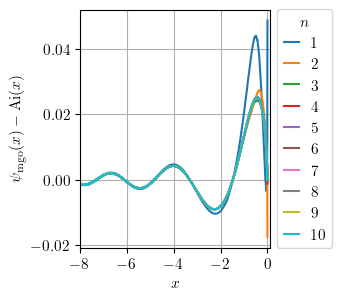

In [493]:
xi = np.linspace(-8, 0, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)

linestyles = ['-']
colors = list(mpl.colors.TABLEAU_COLORS.values())

ns = []
max_errs_quad = []
for i, sol in enumerate(num_study_quad):
    ns.append(sol['n'])
    ray_field_i, field_i, A0_i = (sol[key] for key in ['ray_field', 'field', 'A0'])
    err = np.real(field_i(xi)) - Ai(xi)
    max_errs_quad.append(np.max(np.abs(err)))
    # ax.plot(xs[i_start:i_end], np.real(A0_i*ray_field_i), label='$n=' + str(sol['n']) + '$')
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    
    # ax[0].plot(xi, max_errs_quad[i]*np.ones_like(xi), linestyle, color=color)
    ax.plot(xi, err, linestyle, color=color, label='$' + str(sol['n']) + '$')
    # ax.plot(xi, np.abs(field_i(xi) - Ai(xi)), linestyles[i % len(linestyles)], label='$n=' + str(sol['n']) + '$')
# ax.set_yscale('log')
ax.grid()
# ax.set_ylim(-0.5e-1, 0.5e-1)
ax.set_xlim(np.min(xi), np.max(xi)+1e-1)
ax.set_xticks([-8, -6, -4, -2, 0])
# ax.legend(ncols=4, bbox_to_anchor=(0.5,-0.28), loc="upper center", handlelength=1)
ax.legend(ncols=1, bbox_to_anchor=(1,0.5), loc="center left", title='$n$', handlelength=1)
ax.set_ylabel('$\psi_{\mathrm{mgo}}(x) - \mathrm{Ai}(x)$')
ax.set_xlabel('$x$')
plt.show()

##### Option 2: Relative Error as function of position

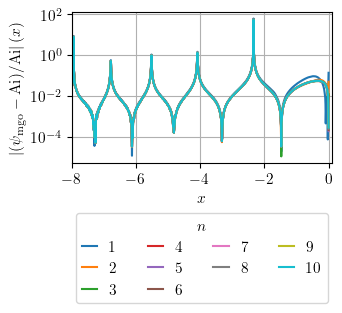

In [507]:
xi = np.linspace(-8, 0, 1000)

ns = []
max_errs_quad = []
mean_errs_quad = []
max_rel_errs_quad = []

fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)

linestyles = ['-']
colors = list(mpl.colors.TABLEAU_COLORS.values())

for i, sol in enumerate(num_study_quad):
    ns.append(sol['n'])
    ray_field_i, field_i, A0_i = (sol[key] for key in ['ray_field', 'field', 'A0'])
    err = np.real(field_i(xi)) - Ai(xi)
    rel_err = np.abs(err/Ai(xi))
    max_errs_quad.append(np.max(np.abs(err)))
    mean_errs_quad.append(np.mean(np.abs(err)))
    max_rel_errs_quad.append(np.max(rel_err))
    # ax.plot(xs[i_start:i_end], np.real(A0_i*ray_field_i), label='$n=' + str(sol['n']) + '$')
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    
    # ax[0].plot(xi, max_errs_quad[i]*np.ones_like(xi), linestyle, color=color)
    ax.plot(xi, rel_err, linestyle, color=color, label='$' + str(sol['n']) + '$')

ax.grid()
# ax.set_ylim(-0.5e-1, 0.5e-1)
ax.set_xlim(np.min(xi), np.max(xi)+1e-1)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.legend(ncols=4, bbox_to_anchor=(0.5,-0.28), loc="upper center", title='$n$', handlelength=1)
# ax.legend(ncols=1, bbox_to_anchor=(1,0.5), loc="center left", title='$n$')
ax.set_ylabel('$\\left| (\psi_{\mathrm{mgo}} - \mathrm{Ai})/\mathrm{Ai} \\right|(x)$')
ax.set_xlabel('$x$')
ax.set_yscale('log')
plt.show()

##### Option 3: Maximal Absolute Error as function of quadrature order (Best)

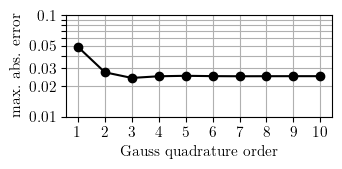

In [524]:
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 4*cm), constrained_layout=True)
ax.grid()
ax.plot(ns, max_errs_quad, 'k-o')
ax.set_ylabel('max. abs. error')
ax.set_yscale('log')
ax.set_ylim(1e-2, 10e-2)
ax.set_yticks(np.arange(1, 11)*1e-2, labels=['$0.01$', '$0.02$', '$0.03$', '', '$0.05$', '', '', '', '', '$0.1$'])
# ax.set_ylim(2e-2, 5e-2)
# ax.set_yticks(np.arange(2, 6)*1e-2, labels=np.arange(2, 6)*1e-2)
ax.set_xticks(ns, labels=ns)
ax.set_xlabel('Gauss quadrature order')
# ax.legend()
plt.savefig('./plots/airy_err_quad.pdf')
# ax.set_ylabel('max. err.')
plt.show()

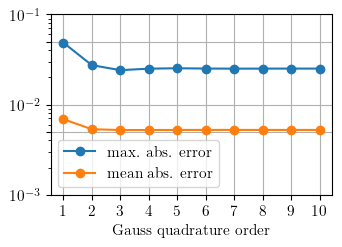

In [496]:
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 6*cm), constrained_layout=True)
ax.grid()
ax.plot(ns, max_errs_quad, '-o', label='max. abs. error')
ax.plot(ns, mean_errs_quad, '-o', label='mean abs. error')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e-1)
ax.set_yticks([1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
ax.set_xticks(ns, labels=ns)
ax.set_xlabel('Gauss quadrature order')
ax.legend()
# ax.set_ylabel('max. err.')
plt.show()

##### Option 4: Maximal Relative Error as function of quadrature order

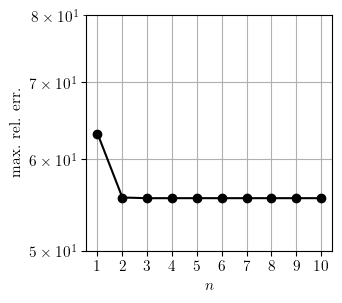

In [378]:
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)
ax.grid()
ax.plot(ns, max_rel_errs_quad, 'k-o')
ax.set_yscale('log')
ax.set_ylim(5e1, 8e1)
ax.set_yticks(np.arange(5, 8)*1e1)
ax.set_xticks(ns, labels=ns)
ax.set_xlabel('$n$')
ax.set_ylabel('max. rel. err.')
plt.show()

#### Barycentric Rational Order

In [497]:
num_study_aaa = []
n = 10
for mmax in [4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]:
    analytic_cont = {'phase': {'fit_func': aaa, 'kwargs': {'mmax': mmax}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': mmax}}}
    _branch_masks, _ray_field, _mgo_info, _results, _Nt, _Upsilon = get_mgo_field(phi0, t, zs, i_start, i_end, analytic_cont=analytic_cont, i_save=i_save, fixed_params={'epsmax': np.inf, 'gauss_quad_order': n})
    _A0, _interp_field = mgo.get_A0_and_interpolation(phi0=phi1, x0=x1, xs=xs, i_start=i_start, i_end=i_end, branch_masks=_branch_masks, ray_field=_ray_field)
    _field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=_branch_masks, ray_field=_ray_field, i_start=i_start, i_end=i_end)
    _sorted_results=sorted(results, key=lambda d: d['t1'])
    num_study_aaa.append({
        'mmax': mmax,
        'branch_masks': _branch_masks, 'ray_field': _ray_field, 'mgo_info': _mgo_info, 'results': _results, 'Nt': _Nt, 'Upsilon': _Upsilon,
        'A0': _A0, 'interp_field': _interp_field,
        'field': _field,
        'sorted_results': _sorted_results
    })

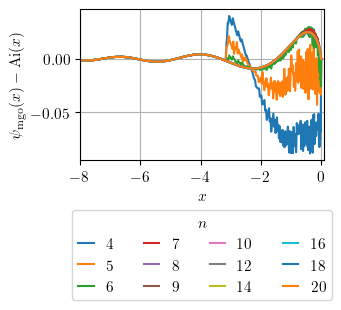

In [498]:
xi = np.linspace(-8, 0, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)

linestyles = ['-']
colors = list(mpl.colors.TABLEAU_COLORS.values())

ms = []
max_errs_aaa = []
for i, sol in enumerate(num_study_aaa):
    ms.append(sol['mmax'])
    ray_field_i, field_i, A0_i = (sol[key] for key in ['ray_field', 'field', 'A0'])
    err = np.real(field_i(xi)) - Ai(xi)
    max_errs_aaa.append(np.max(np.abs(err)))
    # ax.plot(xs[i_start:i_end], np.real(A0_i*ray_field_i), label='$n=' + str(sol['n']) + '$')
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    
    # ax[0].plot(xi, max_errs_aaa[i]*np.ones_like(xi), linestyle, color=color)
    ax.plot(xi, err, linestyle, color=color, label='$' + str(sol['mmax']) + '$')
    # ax.plot(xi, np.abs(field_i(xi) - Ai(xi)), linestyles[i % len(linestyles)], label='$n=' + str(sol['n']) + '$')
# ax.set_yscale('log')
ax.grid()
# ax.set_ylim(-5e-1, 5e-1)
ax.set_xlim(np.min(xi), np.max(xi)+1e-1)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.legend(ncols=4, bbox_to_anchor=(0.5,-0.28), loc="upper center", title='$n$', handlelength=1)
# ax.legend(ncols=1, bbox_to_anchor=(1,0.5), loc="center left", title='$n$')
ax.set_ylabel('$\psi_{\mathrm{mgo}}(x) - \mathrm{Ai}(x)$')
ax.set_xlabel('$x$')
plt.show()

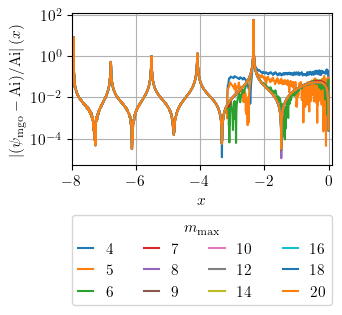

In [499]:
xi = np.linspace(-8, 0, 1000)

ms = []
max_errs_aaa = []
mean_errs_aaa = []
max_rel_errs_aaa = []

fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 7.4*cm), constrained_layout=True)

linestyles = ['-']
colors = list(mpl.colors.TABLEAU_COLORS.values())

for i, sol in enumerate(num_study_aaa):
    ms.append(sol['mmax'])
    ray_field_i, field_i, A0_i = (sol[key] for key in ['ray_field', 'field', 'A0'])
    err = np.real(field_i(xi)) - Ai(xi)
    rel_err = np.abs(err/Ai(xi))
    max_errs_aaa.append(np.max(np.abs(err)))
    mean_errs_aaa.append(np.mean(np.abs(err)))
    max_rel_errs_aaa.append(np.max(rel_err))
    # ax.plot(xs[i_start:i_end], np.real(A0_i*ray_field_i), label='$n=' + str(sol['n']) + '$')
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    
    # ax[0].plot(xi, max_errs[i]*np.ones_like(xi), linestyle, color=color)
    ax.plot(xi, rel_err, linestyle, color=color, label='$' + str(sol['mmax']) + '$')

ax.grid()
# ax.set_ylim(-0.5e-1, 0.5e-1)
ax.set_xlim(np.min(xi), np.max(xi)+1e-1)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.legend(ncols=4, bbox_to_anchor=(0.5,-0.28), loc="upper center", title='$m_{\mathrm{max}}$', handlelength=1)
# ax.legend(ncols=1, bbox_to_anchor=(1,0.5), loc="center left", title='$n$')
ax.set_ylabel('$\\left| (\psi_{\mathrm{mgo}} - \mathrm{Ai})/\mathrm{Ai} \\right|(x)$')
ax.set_xlabel('$x$')
ax.set_yscale('log')
plt.show()

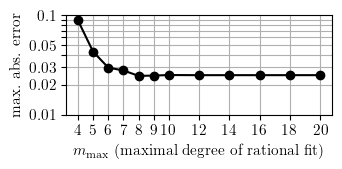

In [523]:
fig, ax = plt.subplots(1, 1, figsize=(8.4*cm, 4*cm), constrained_layout=True)
ax.grid()
ax.plot(ms, max_errs_aaa, 'k-o')
ax.set_ylabel('max. abs. error')
ax.set_yscale('log')
ax.set_ylim(1e-2, 10e-2)
ax.set_yticks(np.arange(1, 11)*1e-2, labels=['$0.01$', '$0.02$', '$0.03$', '', '$0.05$', '', '', '', '', '$0.1$'])
ax.set_xticks(ms, labels=ms)
ax.set_xlabel('$m_{\mathrm{max}}$ (maximal degree of rational fit)')
# ax.legend()
plt.savefig('./plots/airy_err_aaa.pdf')
# ax.set_ylabel('max. err.')
plt.show()

In [519]:
max_errs_aaa[-1]

0.025051568010309944

## Larger Plots

The plots below are not included in the article.

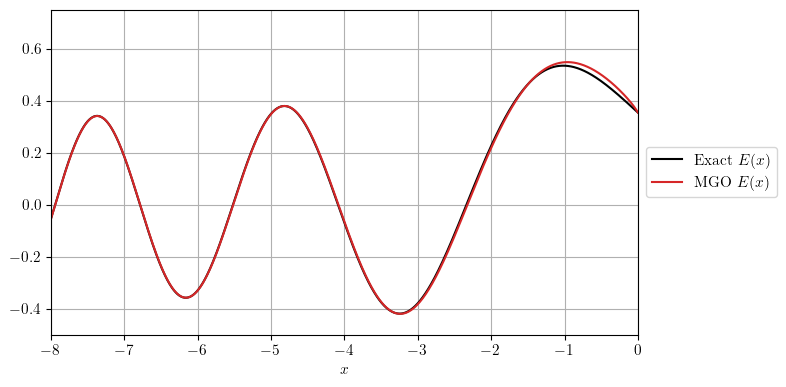

In [16]:
xi = np.linspace(-8, 0, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(xi, Ai(xi), 'k-', label='Exact $E(x)$')
# ax.plot(xi, np.real(field_go(xi)), '--', color='tab:orange', label='GO $E(x)$')
ax.plot(xi, np.real(field(xi)), '-', color='tab:red', label='MGO $E(x)$')
ax.grid()
ax.set_xlim(np.min(xi), np.max(xi))
ax.set_ylim(-0.5, 0.75)
ax.legend(bbox_to_anchor=(1,0.5), loc="center left")
ax.set_xlabel('$x$')
fig.tight_layout()
plt.savefig('./plots/airy_mgo.pdf')
plt.savefig('./plots/airy_mgo.png', dpi=300)
plt.show()

#### GO Results

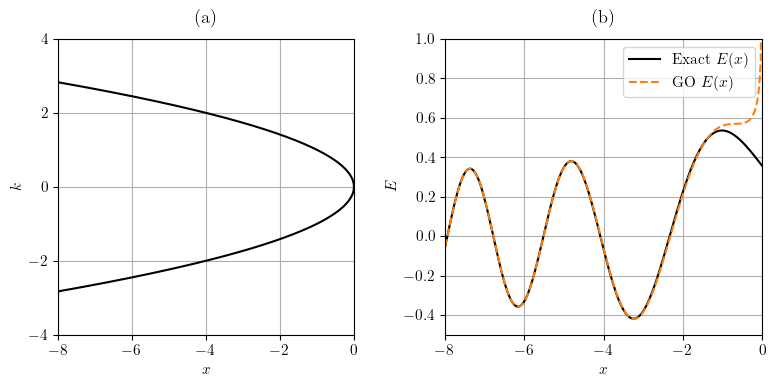

In [42]:
xi = np.linspace(-8, 0, 200)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[4, 4])

ax[0].grid()
ax[0].plot(xs, ks, 'k-')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$k$')
ax[0].set_aspect('equal',adjustable='box')
ax[0].set_title('(a)')
ax[0].set_xlim(-8, 0)
ax[0].set_xticks([-8, -6, -4, -2, 0])
ax[0].set_yticks([-4, -2, 0, 2, 4])

ax[1].plot(xi, E_ex, 'k-', label='Exact $E(x)$')
ax[1].plot(xi, np.real(field_go(xi)), '--', color='tab:orange', label='GO $E(x)$')
ax[1].grid()
ax[1].set_xlim(np.min(xi), np.max(xi))
ax[1].set_ylim(-0.5, 1)
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$E$')
ax[1].set_title('(b)')

fig.tight_layout()
plt.savefig('./plots/airy_GO.pdf')
plt.savefig('./plots/airy_GO.png', dpi=300)
plt.show()

#### Detailed Results - Metaplectically transformed fields and steepest descent paths

In [43]:
C = lambda l, sigma_p, sigma_m, lamb: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: lamb*np.exp(1j*sigma_m), lambda l: lamb*np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m, lamb: np.real(C(l, sigma_p, sigma_m, lamb))
C_I = lambda l, sigma_p, sigma_m, lamb: np.imag(C(l, sigma_p, sigma_m, lamb))

def get_eps(lamb, gauss_quad_order):
    l_j, _ = get_nodes_and_weights(gauss_quad_order)
    lmax = np.max(l_j)
    l_j = l_j.astype(np.complex_)

    epsmax = max(lamb * lmax)
    eps_R = np.linspace(-epsmax,epsmax, 1000)
    eps_I = np.linspace(-epsmax,epsmax, 1000)
    Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
    Eps = Eps_R + 1j*Eps_I
    return Eps_R, Eps_I, Eps, l_j

from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 14

cm = 1/2.54 # 1 cm = 1/2.54 inch

/usr/local/anaconda3/envs/mgo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


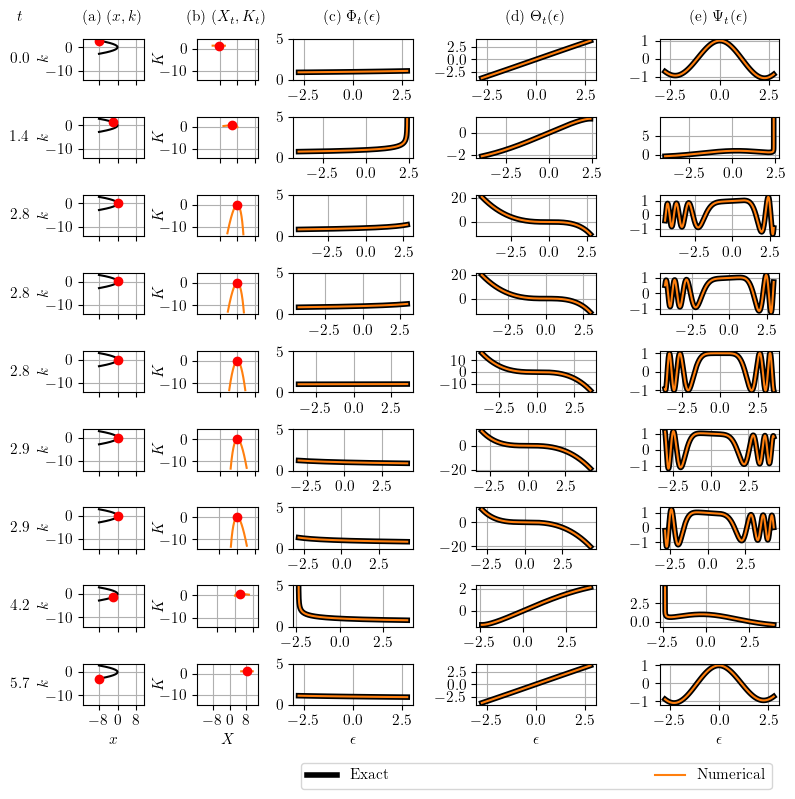

In [44]:
nrows = 2+len(sorted_results)*3
n_cols = 14
fig = plt.figure(constrained_layout=True, figsize=(19.9*cm, 20*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == len(sorted_results) - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 5), slice(5, 8), slice(8, 11), slice(11, 14)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $(X_t, K_t)$', r'(c) $\Phi_t(\epsilon)$', r'(d) $\Theta_t(\epsilon)$', r'(e) $\Psi_t(\epsilon)$']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

for i, result in enumerate(sorted_results):
    t1, it_all, mask_t1, it1, eps_rho, Xs_t1, Ks_t1, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'it1', 'eps_rho', 'Xs_t1', 'Ks_t1', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 1)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(xs, ks, '-', alpha=0)
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.plot(Xs_t1.squeeze(), Ks_t1.squeeze(), '-', color='tab:orange')
    ax.plot(Xs_t1[it1], Ks_t1[it1], 'ro')
    ax.grid()
    ax.set_ylabel(r'$K$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$X$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, Phi_ex(eps_rho, ks[it_all]), '-', linewidth=4, color='k')
    ax.plot(eps_rho, Phi_t1, '-', color='tab:orange')
    ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    ax.plot(eps_rho, Theta_ex(eps_rho, ks[it_all]), '-', linewidth=4, color='k')
    ax.plot(eps_rho, Theta_t1, '-', color='tab:orange')
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[5]])
    ax.plot(eps_rho, np.real(Phi_ex(eps_rho, ks[it_all]) * np.exp(1j*Theta_ex(eps_rho, ks[it_all]))), '-', linewidth=4, color='k')
    ax.plot(eps_rho, np.real(Phi_t1 * np.exp(1j*Theta_t1)), '-', color='tab:orange')
    # ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

ax = fig.add_subplot(gs[-1:, slice(col_ranges[-3].start, col_ranges[-1].stop)])
ax.plot(1, '-', color='k', linewidth=4, label='Exact')
ax.plot(1, '-', color='tab:orange', label='Numerical')
plt.axis('off')
ax.legend(mode='expand', ncols=2)

fig.savefig('./plots/airy_mgo_steps_1.pdf')
fig.savefig('./plots/airy_mgo_steps_1.png', dpi=300)
plt.show()

/usr/local/anaconda3/envs/mgo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


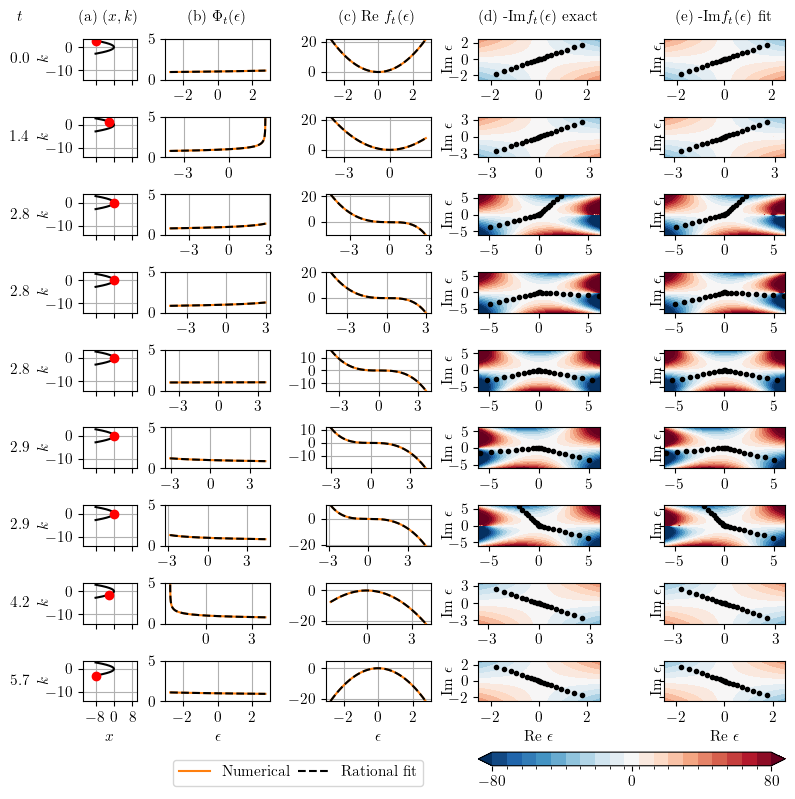

In [47]:
vmin, vmax = -80, 80
cmap = mpl.cm.RdBu_r
levels = np.linspace(vmin, vmax, 20)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')

nrows = 2+len(sorted_results)*3
n_cols = 15
fig = plt.figure(constrained_layout=True, figsize=(19.9*cm, 20*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == len(sorted_results) - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 6), slice(6, 9), slice(9, 12), slice(12, 15)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $\Phi_t(\epsilon)$', r'(c) Re $f_t(\epsilon)$', r'(d) -Im$f_t(\epsilon)$ exact', r'(e) -Im$f_t(\epsilon)$ fit']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

get_eps_xticks = lambda eps_rho: [-5]*int(np.min(eps_rho) <= -5) + [-2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [0] + [2]*int(np.min(eps_rho) > -5 and np.max(eps_rho) < 5) + [5]*int(np.max(eps_rho) >= 5)

for i, result in enumerate(sorted_results):
    t1, it_all, mask_t1, eps_rho, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 1)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.plot(results[-1]['Xs_t1'].squeeze(), results[-1]['Ks_t1'].squeeze(), '-', alpha=0)
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-8, 0, 8])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-8, 0, 8], labels=[])
    ax.set_xlim(-8, 8)
    ax.axis('equal')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(eps_rho, Phi_t1, '-', color='tab:orange')
    ax.plot(eps_rho, g_fit(eps_rho), '--', color='k')
    ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(eps_rho))*2/3))))
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, f_t1, '-', color='tab:orange')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='k')
    ax.set_ylim(max(min(-5, np.min(f_t1)), -50), min(max(5, np.max(f_t1)), 50))
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')
    # ax.set_xticks(get_eps_xticks(eps_rho))
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(eps_rho))*2/3))))

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_ex(Eps.reshape(-1, 1), ks[it_all]).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_R))*2/3))))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_I))*2/3))))

    ax = fig.add_subplot(gs[row_range(i), col_ranges[5]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    plt.tick_params('y', labelleft=False)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_R))*2/3))))
    plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(int(np.ceil(np.max(np.abs(Eps_I))*2/3))))

ax = fig.add_subplot(gs[-1:, slice(col_ranges[2].start, col_ranges[3].stop)])
ax.plot(1, '-', color='tab:orange', label='Numerical')
ax.plot(1, '--', color='k', label='Rational fit')
plt.axis('off')
ax.legend(mode='expand', ncols=2)

cax = fig.add_subplot(gs[-1:, slice(col_ranges[-2].start, col_ranges[-1].stop)])
c_ticks = [vmin, 0, vmax]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, ticks=c_ticks, orientation='horizontal', extend='both')

fig.savefig('./plots/airy_mgo_steps_2.pdf')
fig.savefig('./plots/airy_mgo_steps_2.png', dpi=300)
plt.show()